In [3]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

In [4]:
df = pd.read_csv('Household energy bill data.csv')

In [5]:
df.head()

,num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,amount_paid
0,3,3,742.57,1,1,1,9675.93,2,0,560.481447
1,1,5,952.99,0,1,0,35064.79,1,1,633.283679
2,3,1,761.44,1,1,1,22292.44,0,0,511.879157
3,0,5,861.32,1,1,0,12139.08,0,0,332.992035
4,1,8,731.61,0,1,0,17230.10,2,1,658.285625


In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

num_rooms             0
num_people            0
housearea             0
is_ac                 0
is_tv                 0
is_flat               0
ave_monthly_income    0
num_children          0
is_urban              0
amount_paid           0
dtype: int64

<Axes: >

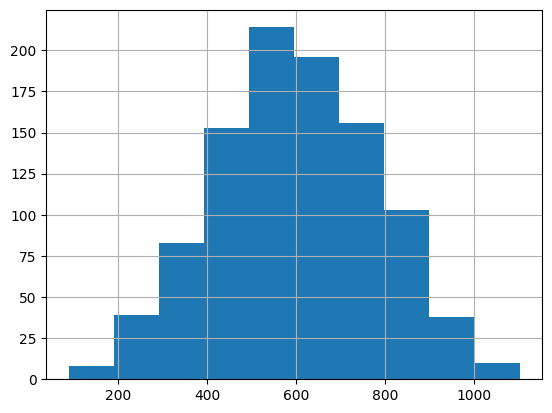

In [8]:
df['amount_paid'].hist()

In [9]:
df.columns

Index(['num_rooms', 'num_people', 'housearea', 'is_ac', 'is_tv', 'is_flat',
       'ave_monthly_income', 'num_children', 'is_urban', 'amount_paid'],
      dtype='object')

In [10]:
X = df[['num_rooms', 'num_people', 'housearea', 'is_ac', 'is_tv', 'is_flat',
       'ave_monthly_income', 'num_children', 'is_urban']]

# have only the target variable here (dependent variable)
y = df['amount_paid']

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)

In [20]:
training_variable_amount = len(X.columns)

from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)


model = keras.Sequential(
    [
        layers.Dense(12, activation="relu", input_shape=(training_variable_amount,)),
        layers.Dense(8, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(4, activation="relu"),
        layers.Dense(1)
    ]
)

model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(x=X_train, y=y_train, epochs=1500, validation_data=(X_val, y_val), callbacks=[mc])

Model: "sequential_1"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12)                120       
                                                                 
 dense_5 (Dense)             (None, 8)                 104       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_6 (Dense)             (None, 4)                 36        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 265 (1.04 KB)
Trainable params: 265 (1.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1500
22/22 [==========================

<Axes: >

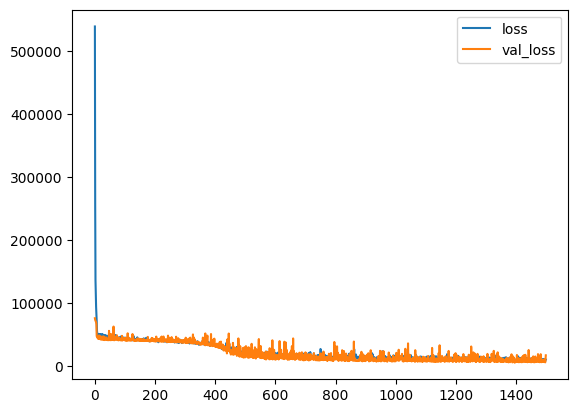

In [21]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [22]:
from keras.models import load_model
best_model = load_model('best_model.keras')

In [23]:
# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
16607.2578125

Train data evaluation:
17689.2734375


In [24]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

5/5 [==============================] - 0s 5ms/step


,Test True Y,Model Predictions
0,529.752567,445.960022
1,725.970313,543.587524
2,742.379815,596.128906
3,675.483254,523.133118
4,485.738650,347.747314
...,...,...
145,439.728088,373.793396
146,800.416867,662.771729
147,562.955168,467.087830
148,473.820453,503.796417


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

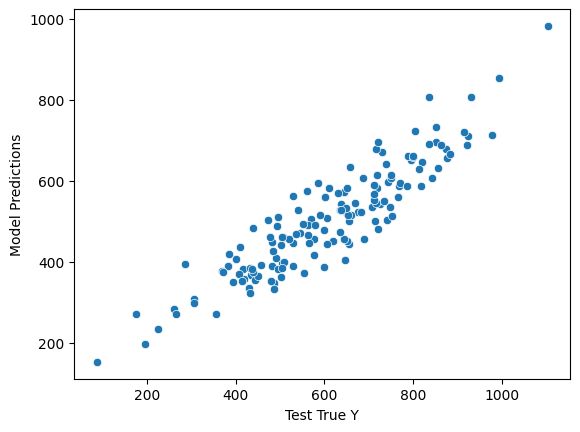

In [25]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [26]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
109.58 $

MSE
16607.26 $^2

RMSE:
128.87 $

R-squared:
0.48

Explained variance score:
0.81


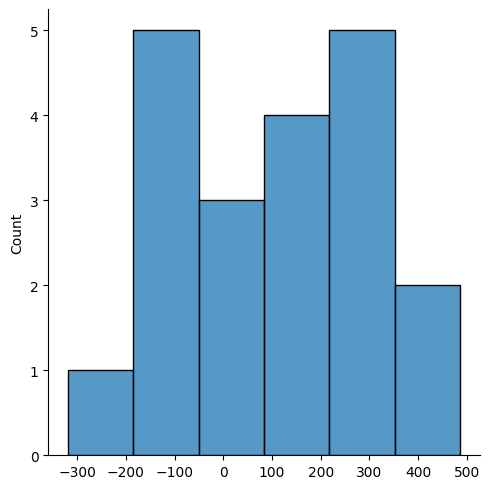

In [27]:
sns.displot((y_test - test_predictions))
plt.show()
plt.close()

In [28]:
tester_row = {
    'num_rooms': 4,
    'num_people': 3,
    'housearea': 830,
    'is_ac': 1,
    'is_tv': 1,
    'is_flat': 0,
    'ave_monthly_income': 20000,
    'num_children': 1,
    'is_urban': 0
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

result = model.predict(tester_row)[0]

print()
print(f"Estimated energy bill:")
print(f"{round(float(result), 2)}")
print("----------------")

1/1 [==============================] - 0s 179ms/step

Estimated energy bill:
434.94
----------------


C:\Users\Roman\AppData\Local\Temp\ipykernel_6084\103948531.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"{round(float(result), 2)}")
